# Implementing a Neural Network for CIFAR dataset


## 1) Loading CIFAR dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

dataloaders = {
    "train": trainloader,
    "val": valloader
}

dataset_sizes = {
    "train": trainset.data.shape[0],
    "val": valset.data.shape[0]
}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 


In [6]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

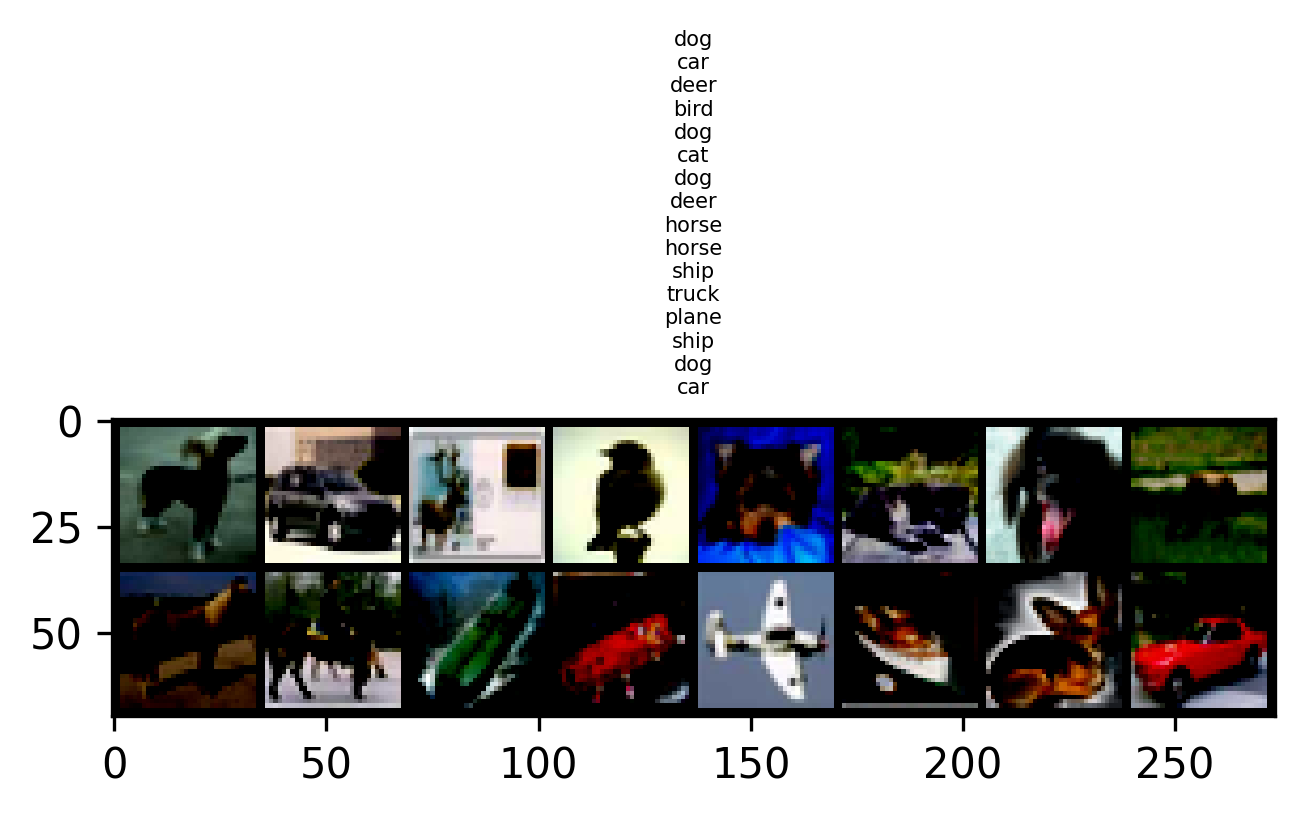

In [8]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## Baseline network

In [9]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_results = {p: [] for p in ['train', 'val']}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_results[phase].append({'epoch': epoch, 'epoch_loss': epoch_loss, 'epoch_acc': epoch_acc})

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_results

In [10]:
import seaborn as sns
import pandas as pd

def get_unified_stats_df(stats):
  train_stats_df = pd.DataFrame(stats['train'])
  train_stats_df['Dataset'] = 'train'
  train_stats_df.epoch_acc = train_stats_df.epoch_acc.apply(lambda x: x.cpu().detach().numpy())
  val_stats_df = pd.DataFrame(stats['val'])
  val_stats_df['Dataset'] = 'validation'
  val_stats_df.epoch_acc = val_stats_df.epoch_acc.apply(lambda x: x.cpu().detach().numpy())
  return pd.concat([train_stats_df, val_stats_df]).reset_index(drop=True)


In [30]:
class BaseNeuralNetwork(nn.Module):
    """
    Baseline network for the experiment
    """
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        
        self.layer6 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()      
        )

        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * 8, 10),
            nn.ReLU()
        )


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.fc(out)
        return out


In [31]:
m = BaseNeuralNetwork()
m

BaseNeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer6): Sequential(
    (0): 

In [32]:
def train_model_end2end(nn_obj, criterion, num_epochs, sgd_lr, sgd_momentum, sgd_nesterov):
  model = nn_obj.to(device)
  model = model.to(device)
  optimizer_ft = optim.SGD(model.parameters(), lr=sgd_lr, momentum=sgd_momentum)

  # Decay LR by a factor of 0.1 every 7 epochs - I did not change it as recommended in the above instructions
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model, stats = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)
  
  return model, stats

In [33]:
base_model_configurations = [
 {
    "config_name": "nn_base",
    "params": {"nn_obj": BaseNeuralNetwork(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.01,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 10} 
 }
]



base_results = []

for model_conf in base_model_configurations:
  conf_name = model_conf.get('config_name')
  params = model_conf.get('params')
  
  print(f"\n\nStarting to train model with conf name - {conf_name}")
  model, stats = train_model_end2end(**params)
  unified_stats_df = get_unified_stats_df(stats)

  base_results.append((conf_name, model, unified_stats_df))




Starting to train model with conf name - nn_base
Epoch 0/9
----------
train Loss: 1.5088 Acc: 0.4555
val Loss: 1.2273 Acc: 0.5654

Epoch 1/9
----------
train Loss: 1.1269 Acc: 0.5996
val Loss: 1.1334 Acc: 0.5922

Epoch 2/9
----------
train Loss: 1.0291 Acc: 0.6352
val Loss: 1.0988 Acc: 0.6078

Epoch 3/9
----------
train Loss: 0.9776 Acc: 0.6525
val Loss: 1.0022 Acc: 0.6453

Epoch 4/9
----------
train Loss: 0.9445 Acc: 0.6674
val Loss: 1.1126 Acc: 0.6114

Epoch 5/9
----------
train Loss: 0.9143 Acc: 0.6771
val Loss: 0.9810 Acc: 0.6557

Epoch 6/9
----------
train Loss: 0.8991 Acc: 0.6845
val Loss: 0.9898 Acc: 0.6474

Epoch 7/9
----------
train Loss: 0.8249 Acc: 0.7106
val Loss: 0.9054 Acc: 0.6808

Epoch 8/9
----------
train Loss: 0.8113 Acc: 0.7150
val Loss: 0.9092 Acc: 0.6818

Epoch 9/9
----------
train Loss: 0.8067 Acc: 0.7169
val Loss: 0.9024 Acc: 0.6846

Training complete in 2m 59s
Best val Acc: 0.684600


In [34]:
# !pip install torchsummary 
from torchsummary import summary
summary(m.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
            Conv2d-4            [-1, 8, 32, 32]             584
       BatchNorm2d-5            [-1, 8, 32, 32]              16
              ReLU-6            [-1, 8, 32, 32]               0
         MaxPool2d-7            [-1, 8, 16, 16]               0
              ReLU-8            [-1, 8, 16, 16]               0
            Conv2d-9            [-1, 8, 16, 16]             584
      BatchNorm2d-10            [-1, 8, 16, 16]              16
             ReLU-11            [-1, 8, 16, 16]               0
           Conv2d-12            [-1, 8, 16, 16]             584
      BatchNorm2d-13            [-1, 8, 16, 16]              16
             ReLU-14            [-1, 8,

It seems that V5 network that we created above (the widest one) yielded the best results, I'll take it as our baseline model and try to optimize it using the hyperparams.
I've also increased the epochs to 30 as I want to see us getting stuck or overfitting and I did not see it yet.

In [51]:

base_results

[('nn_base', BaseNeuralNetwork2(
    (layer1): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ReLU()
    )
    (layer4): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer5): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### Other tests

In [52]:
class BaseNeuralNetwork2(nn.Module):
    """
    Baseline network for the experiment
    """
    def __init__(self):
        super(BaseNeuralNetwork2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        
        self.layer6 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()      
        )

        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * 8, 10),
            nn.ReLU()
        )


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.fc(out)
        return out

In [53]:
base_model_configurations = [
 {
    "config_name": "nn_base",
    "params": {"nn_obj": BaseNeuralNetwork2(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.01,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 20} 
 }
]



base_results = []

for model_conf in base_model_configurations:
  conf_name = model_conf.get('config_name')
  params = model_conf.get('params')
  
  print(f"\n\nStarting to train model with conf name - {conf_name}")
  model, stats = train_model_end2end(**params)
  unified_stats_df = get_unified_stats_df(stats)

  base_results.append((conf_name, model, unified_stats_df))




Starting to train model with conf name - nn_base
Epoch 0/19
----------
train Loss: 1.6548 Acc: 0.4222
val Loss: 1.4225 Acc: 0.5263

Epoch 1/19
----------
train Loss: 1.2774 Acc: 0.5548
val Loss: 1.2075 Acc: 0.5709

Epoch 2/19
----------
train Loss: 1.0957 Acc: 0.6096
val Loss: 1.1786 Acc: 0.5914

Epoch 3/19
----------
train Loss: 1.0043 Acc: 0.6434
val Loss: 1.1806 Acc: 0.5892

Epoch 4/19
----------
train Loss: 0.9548 Acc: 0.6600
val Loss: 0.9667 Acc: 0.6574

Epoch 5/19
----------
train Loss: 0.9157 Acc: 0.6781
val Loss: 0.9643 Acc: 0.6605

Epoch 6/19
----------
train Loss: 0.8897 Acc: 0.6876
val Loss: 0.9663 Acc: 0.6601

Epoch 7/19
----------
train Loss: 0.8172 Acc: 0.7134
val Loss: 0.8835 Acc: 0.6884

Epoch 8/19
----------
train Loss: 0.8045 Acc: 0.7170
val Loss: 0.8899 Acc: 0.6865

Epoch 9/19
----------
train Loss: 0.7987 Acc: 0.7201
val Loss: 0.8814 Acc: 0.6885

Epoch 10/19
----------
train Loss: 0.7947 Acc: 0.7211
val Loss: 0.8810 Acc: 0.6895

Epoch 11/19
----------
train Loss: 

In [50]:
from torchsummary import summary
summary(BaseNeuralNetwork2().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
            Conv2d-4            [-1, 8, 32, 32]             584
       BatchNorm2d-5            [-1, 8, 32, 32]              16
              ReLU-6            [-1, 8, 32, 32]               0
         MaxPool2d-7            [-1, 8, 16, 16]               0
              ReLU-8            [-1, 8, 16, 16]               0
            Conv2d-9            [-1, 8, 16, 16]             584
      BatchNorm2d-10            [-1, 8, 16, 16]              16
             ReLU-11            [-1, 8, 16, 16]               0
           Conv2d-12            [-1, 8, 16, 16]             584
      BatchNorm2d-13            [-1, 8, 16, 16]              16
             ReLU-14            [-1, 8,